<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [20]:
!pip3 install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [21]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.7
IPython 7.15.0

numpy 1.19.0
scipy 1.5.0
pandas 1.0.5
matplotlib 3.2.2
statsmodels not installed
sklearn 0.0

compiler   : Clang 11.0.0 (clang-1100.0.33.17)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 1b296626acb64bfd0fe8057a689e5904f604fa24


In [22]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [23]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [24]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [25]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [27]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [28]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs = -1)

In [31]:
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [32]:
y_train

array(['237', '207', '207', ..., '127', '128', '39'], dtype=object)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [33]:
knn_cv_scores_train = cross_val_score(knn, X_train.todense(), y_train, cv = skf, n_jobs = -1)

In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=100)

In [35]:
print(round(np.mean(knn_cv_scores_train), 3), round(accuracy_score(knn.predict(X_valid), y_valid), 3))

0.555 0.583


In [80]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

write_answer_to_file("{} {}".format(round(np.mean(knn_cv_scores_train), 3), round(accuracy_score(knn.predict(X_valid), y_valid), 3)), 'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
forest = RandomForestClassifier(n_estimators = 100, random_state = 17, oob_score = True, n_jobs = -1)
forest.fit(X_train, y_train)
forest.oob_score_

0.7222109327372486

In [38]:
accuracy_score(forest.predict(X_valid), y_valid)

0.7383266176819151

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [157]:
write_answer_to_file("{} {}".format(forest.oob_score_.round(3), accuracy_score(forest.predict(X_valid), y_valid).round(3)),
                     'answer4_2.txt')

In [158]:
!cat answer4_2.txt

0.722 0.738

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [41]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [42]:
logit = LogisticRegression(random_state = 17, n_jobs = -1)

In [43]:
logit.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=17)

In [49]:
logit_cv_scores_train = np.mean(cross_val_score(logit, X_train, y_train, cv = skf, n_jobs = -1))

In [50]:
logit_score_valid = accuracy_score(logit.predict(X_valid), y_valid)

In [51]:
print(np.round(logit_cv_scores_train, 3), np.round(logit_score_valid, 3))

0.763 0.776


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [53]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, multi_class = 'multinomial', random_state = 17, cv = skf, n_jobs = -1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 4.28 s, sys: 639 ms, total: 4.91 s
Wall time: 19.5 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [66]:
logit_mean_cv_scores1 = np.array([matr.mean(axis = 0) for key, matr in logit_grid_searcher1.scores_.items()]).mean(axis = 0)
logit_mean_cv_scores1

array([0.30979482, 0.47073834, 0.55456242, 0.65230726, 0.71774131,
       0.75116884, 0.76265016, 0.76173568, 0.75563908, 0.74537746])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [68]:
print('best accuracy:', np.max(logit_mean_cv_scores1), ', C:',  logit_c_values1[np.argmax(logit_mean_cv_scores1)])

best accuracy: 0.7626501624281711 , C: 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

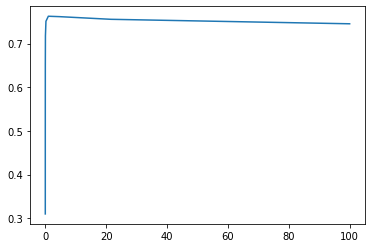

In [69]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [72]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, multi_class = 'multinomial', random_state = 17, cv = skf, n_jobs = -1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 4.04 s, sys: 727 ms, total: 4.76 s
Wall time: 50.4 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [73]:
logit_mean_cv_scores2 = np.array([matr.mean(axis = 0) for key, matr in logit_grid_searcher2.scores_.items()]).mean(axis = 0)
logit_mean_cv_scores2

array([0.73724926, 0.75817933, 0.76264995, 0.76386936, 0.76325967,
       0.7634628 , 0.76386921, 0.76315798, 0.76264991, 0.7623451 ,
       0.76163393, 0.76112587, 0.75950013, 0.75980497, 0.76010982,
       0.76000829, 0.75960191, 0.75939869, 0.75960188, 0.75909384])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [76]:
print('best accuracy:', np.max(logit_mean_cv_scores2), ', C:',  logit_c_values2[np.argmax(logit_mean_cv_scores2)])

best accuracy: 0.7638693648823108 , C: 1.1894736842105265


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

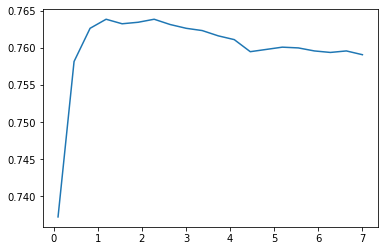

In [77]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [79]:
C = logit_c_values2[np.argmax(logit_mean_cv_scores2)]
logit_cv_acc = accuracy_score(LogisticRegression(random_state = 17, n_jobs = -1, C = C).fit(X_train, y_train).predict(X_valid),
                             y_valid)
logit_cv_acc

0.77767243422612

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [81]:
write_answer_to_file("{} {}".format(round(np.max(logit_mean_cv_scores2), 3), 
                                    round(logit_cv_acc, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [83]:
from sklearn.svm import LinearSVC

In [85]:
svm = LinearSVC(C = 1, random_state = 17)

In [92]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv = skf)
svm_cv_scores.mean().round(3)

0.757

In [91]:
accuracy_score(svm.fit(X_train, y_train).predict(X_valid), y_valid).round(3)

0.777

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [145]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(LinearSVC(random_state = 17),
                                  svm_params1,
                                  n_jobs = -1,
                                  cv = skf,
                                  return_train_score = True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.03 s, sys: 30.7 ms, total: 3.06 s
Wall time: 29 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [146]:
print(svm_grid_searcher1.best_score_.round(3), svm_grid_searcher1.best_params_)

0.699 {'C': 4444.4445000000005}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

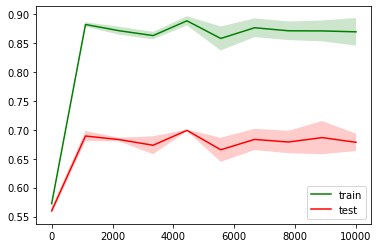

In [148]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [149]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(random_state = 17),
                                  svm_params2,
                                  n_jobs = -1,
                                  cv = skf,
                                  return_train_score = True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.62 s, sys: 99.1 ms, total: 1.72 s
Wall time: 1min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [152]:
print(svm_grid_searcher2.best_score_.round(3), svm_grid_searcher2.best_params_)

0.767 {'C': 0.17324137931034483}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

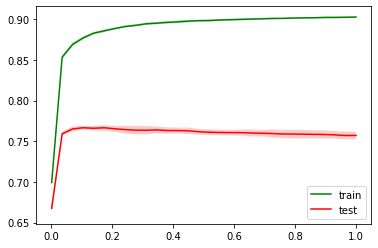

In [151]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [155]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)
svm_cv_acc.round(3)

0.782

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [156]:
write_answer_to_file("{} {}".format(svm_grid_searcher2.best_score_.round(3), svm_cv_acc.round(3)), 'answer4_4.txt') 

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [186]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as f:
        X_sparse = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, random_state=17, stratify = y)
    estimator.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(estimator, X_train, y_train, cv = skf))
    valid_score = accuracy_score(estimator.predict(X_valid), y_valid)
    return cv_score, valid_score

**Убедитесь, что функция работает.**

In [164]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7665113315640929, 0.7824128940507229)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [165]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [173]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, "X_sparse_{}users_s{}_w{}.pkl".format(10, session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, "y_{}users_s{}_w{}.pkl".format(10, session_length, window_size))
        print("session_length:", session_length, "window_size:", window_size,
              "model_asessment:", model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

session_length: 15 window_size: 10 model_asessment: (0.8241219152895582, 0.833372837165205)
session_length: 10 window_size: 10 model_asessment: (0.7665113315640929, 0.7824128940507229)
session_length: 15 window_size: 7 model_asessment: (0.849217328569868, 0.8737348597975776)
session_length: 10 window_size: 7 model_asessment: (0.7994305981531662, 0.8393894143023063)
session_length: 7 window_size: 7 model_asessment: (0.7480080011114308, 0.805873568939771)
session_length: 15 window_size: 5 model_asessment: (0.8712526161612782, 0.8742294926505453)
session_length: 10 window_size: 5 model_asessment: (0.8209022689506731, 0.8406827880512091)
session_length: 7 window_size: 5 model_asessment: (0.7774106942601205, 0.8027501185395922)
session_length: 5 window_size: 5 model_asessment: (0.7281779311848903, 0.7600758653390233)
CPU times: user 30 s, sys: 396 ms, total: 30.4 s
Wall time: 35.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [175]:
res1, res2 = model_assessment(svm_grid_searcher2.best_estimator_,
                              os.path.join(PATH_TO_DATA, "X_sparse_10users_s15_w5.pkl"),
                              os.path.join(PATH_TO_DATA, "y_10users_s15_w5.pkl"),
                              skf)
res = "{} {}".format(res1.round(3), res2.round(3))
write_answer_to_file(res,
                     "answer4_5.txt")
print(res)

0.871 0.874


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [185]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, "X_sparse_{}users_s{}_w{}.pkl".format(150, session_length, window_size))
with open(path_to_X_pkl, 'rb') as f:
    X_sparse = pickle.load(f)
X_sparse.shape

(273957, 27797)

In [187]:
%%time
estimator = svm_grid_searcher2.best_estimator_
from tqdm import tqdm
for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
        path_to_X_pkl = os.path.join(PATH_TO_DATA, "X_sparse_{}users_s{}_w{}.pkl".format(150, session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, "y_{}users_s{}_w{}.pkl".format(150, session_length, window_size))
        print("session_length:", session_length, "window_size:", window_size,
              "model_asessment:", model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

 33%|███▎      | 1/3 [08:53<17:47, 533.95s/it]

session_length: 5 window_size: 5 model_asessment: (0.411203062017323, 0.42043850683798123)


 67%|██████▋   | 2/3 [17:14<08:44, 524.00s/it]

session_length: 7 window_size: 7 model_asessment: (0.4384443568519248, 0.4536567087917703)


100%|██████████| 3/3 [24:38<00:00, 492.82s/it]

session_length: 10 window_size: 10 model_asessment: (0.46343040046708994, 0.4832141293241862)
CPU times: user 24min 9s, sys: 5.58 s, total: 24min 14s
Wall time: 24min 38s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [188]:
res1, res2 = model_assessment(svm_grid_searcher2.best_estimator_,
                              os.path.join(PATH_TO_DATA, "X_sparse_150users.pkl"),
                              os.path.join(PATH_TO_DATA, "y_150users.pkl"),
                              skf)
res = "{} {}".format(res1.round(3), res2.round(3))
write_answer_to_file(res,
                     "answer4_6.txt")
print(res)

0.463 0.483


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [189]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [190]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [197]:
logit_c_values2[np.argmax(logit_mean_cv_scores2)]

1.1894736842105265

In [205]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_c_values2[np.argmax(logit_mean_cv_scores2)]],
                                         multi_class='ovr', n_jobs=-1, random_state=17, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 9min 43s, sys: 1min 19s, total: 11min 3s
Wall time: 8min 31s


LogisticRegressionCV(Cs=[1.1894736842105265],
                     cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [211]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.mean(logit_cv_150users.scores_[user_id]).round(3)))

User 100, CV score: 0.995
User 1014, CV score: 0.997
User 102, CV score: 0.991
User 103, CV score: 0.981
User 1040, CV score: 0.997
User 105, CV score: 0.997
User 1054, CV score: 0.997
User 106, CV score: 0.995
User 118, CV score: 0.991
User 119, CV score: 0.997
User 120, CV score: 0.994
User 1248, CV score: 0.998
User 126, CV score: 0.995
User 1267, CV score: 0.997
User 127, CV score: 0.992
User 128, CV score: 0.985
User 1299, CV score: 0.997
User 13, CV score: 0.996
User 1371, CV score: 0.993
User 138, CV score: 0.997
User 15, CV score: 0.995
User 158, CV score: 0.997
User 16, CV score: 0.992
User 160, CV score: 0.997
User 165, CV score: 0.997
User 172, CV score: 0.997
User 177, CV score: 0.997
User 1797, CV score: 0.995
User 1798, CV score: 0.997
User 1993, CV score: 0.997
User 203, CV score: 0.997
User 207, CV score: 0.987
User 2118, CV score: 0.998
User 2174, CV score: 0.996
User 2191, CV score: 0.995
User 223, CV score: 0.996
User 2250, CV score: 0.997
User 233, CV score: 0.996
U

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [236]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = np.mean(logit_cv_150users.scores_[user_id]) - \
    (sum(class_distr) - class_distr[int(user_id)])/sum(class_distr)


In [238]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

127

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [239]:
write_answer_to_file(num_better_than_default, 'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [249]:
y_binary_128 = [1 if item == '128' else 0 for item in y_150users ]

In [259]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [262]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_150users, train_sizes=train_sizes, cv=skf, n_jobs=-1)

KeyboardInterrupt: 

In [263]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

NameError: name 'val_train' is not defined

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.